In [ ]:
#importing packages
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

Downloaded the RIVM covid data set containing the number of infections reported and the number of deceased reported. RIVM is our national institute for health and environment.
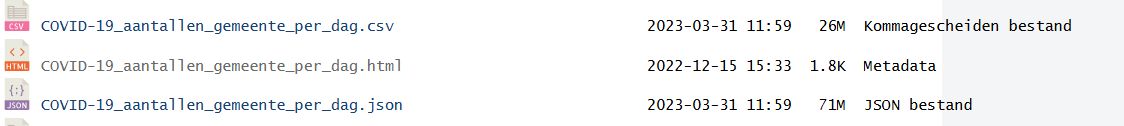


In [ ]:
dataset_path = '~/work/datasets/EDAs/COVID-19_aantallen_gemeente_per_dag.csv'
df = pd.read_csv(dataset_path, sep=';')

First step: checking out the data...

In [ ]:
print(df.shape)
df.head()

In [ ]:
df.columns

In [ ]:
df[df.Municipality_name=='Almere']

In [ ]:
df[df.Municipality_name=='Almere'].Municipality_code.value_counts()

In [ ]:
df.query('(Municipality_name=="Almere" and not Municipality_code=="GM0034") or (not Municipality_name=="Almere" and Municipality_code=="GM0034")')

Date_of_report seems to be constant, same for data of publication. This dataset is published on 2023-03-31.

In [ ]:
print(df['Date_of_report'].value_counts())
print(df['Date_of_publication'].value_counts())

Apparently 1 date of report and 544 dates of publications, each with 370 entries. 
This suggests that date_of_publication does NOT refer to date of publication of this document. Let's delve into the meaning of the various variable a bit more.

From the metadata (https://data.rivm.nl/meta/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427)

    Date_of_report: Date and time on which the data file was created by the RIVM.

    Date_of_publication: This concerns the number of new reports that have been received by the RIVM per day. The time period in which the report was passed on runs from 10:01 AM yesterday to 10:00 AM today. The publication date may differ from the date of the positive test result. This can happen if a report of a positive SARS-CoV-2 test is transferred later by a PHS to the RIVM. This file contains the most up-to-date notifications based on the OSIRIS source file. If corrections are made in OSIRIS, these corrections will also be processed in this file.

Furthermore: 

    The numbers concern Covid-19 reports since the first report in the Netherlands (27/02/2020).
    

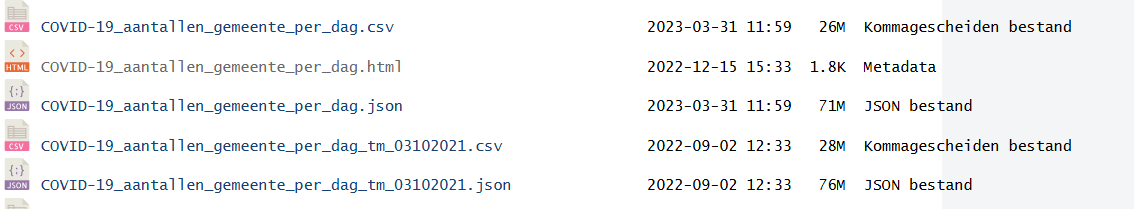

In [ ]:
dataset_path = '~/work/datasets/EDAs/COVID-19_aantallen_gemeente_per_dag_tm_03102021.csv'
df_earlier = pd.read_csv(dataset_path, sep=';')
df = pd.concat([df_earlier,df],ignore_index=True)

In [ ]:
print(df.shape)
df.head()


In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
df.describe(include=['object'])

In [ ]:
df.info()

In [ ]:
df = df.drop(['Municipality_code','Security_region_code'],axis=1)

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df.query('Municipality_name=="Arnhem"'),x='Date_of_publication',y='Deceased')
plt.show()

https://data.rivm.nl/meta/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427

Deceased: The number of deceased persons reported to the PHSs who have tested positive for SARS-CoV-2 and have been published by the RIVM on [Date_of_publication]. The actual number of deceased persons positive for SARS-CoV-2 is higher than the number of reports in the surveillance, because not all deceased persons are tested. This is because there is no obligation to report the death of persons with a positive SARS-CoV-2 test result. From January 1, 2023, this column is set to 9999.

In [ ]:
sns.lineplot(data=df.query('Date_of_publication<"2023-01-01" and Municipality_name=="Arnhem"'),x='Date_of_publication',y='Deceased')
plt.show()

In [ ]:
df[['Date_of_publication','Date_of_report']]=df[['Date_of_publication','Date_of_report']].apply(pd.to_datetime)

In [ ]:
plt.xticks(rotation=45)
sns.lineplot(data=df.query('Date_of_publication<"2023-01-01" and Municipality_name=="Arnhem"'),x='Date_of_publication',y='Deceased')
plt.show()

Let's look at the situation in Amsterdam.

In [ ]:
plt.xticks(rotation=45)
sns.lineplot(data=df.query('Date_of_publication<"2023-01-01" and Municipality_name=="Amsterdam"'),x='Date_of_publication',y='Deceased')
plt.show()

In [ ]:
df.query('Date_of_publication<"2023-01-01" and Municipality_name=="Amsterdam"')

In [ ]:
df.Municipality_name.value_counts()

In [ ]:
df_new = df.drop_duplicates()

In [ ]:
df_new.Municipality_name.value_counts()

Multiple reports on the same day from different ROAZ regions. How to deal with this?

In [ ]:
df_new = df.query('Date_of_publication<"2023-01-01"')

Compare deceased across provinces.
Trick: Pivot tables

In [ ]:
df_piv = df_new.pivot_table(index='Date_of_publication',columns='Province',values='Deceased',aggfunc='sum')
df_piv.head()

In [ ]:
df_piv.plot()
plt.show()

In [ ]:
df_piv.Zeeland.plot()
plt.show()


In [ ]:
df_new.query('Province=="Zeeland" and Date_of_publication>"2021-12-25" and Date_of_publication<"2022-01-01"')[["Date_of_publication","Deceased"]].groupby("Date_of_publication").sum()

In [ ]:
df_new.query('Province=="Zeeland" and Date_of_publication=="2021-12-28"')[['Municipality_name','Deceased']]

In [ ]:
df_new.query('Province=="Zeeland" and Date_of_publication=="2021-12-27"')[['Municipality_name','Deceased']]

In [ ]:
df_new.query('Province=="Zeeland" and Date_of_publication=="2021-12-26"')[['Municipality_name','Deceased']]

In [ ]:
df_new.query('Province=="Zeeland" and Date_of_publication=="2021-12-25"')[['Municipality_name','Deceased']]

In [ ]:
df_piv[['Noord-Brabant','Zuid-Holland','Groningen']].plot()
plt.show()

First Noord-Brabant, then Zuid-Holland, then Groningen (if at all).

In [ ]:
df_piv2 = df_new.pivot_table(index='Date_of_publication',columns='Province',values='Total_reported',aggfunc='sum')

In [ ]:
df_piv2.plot()
plt.show()

In [ ]:
df_piv2.query('Date_of_publication<"2020-08-20"').plot()
plt.show()

Let's compare the deceased and the total reported.

In [ ]:
plt.subplot(1,2,1)
plt.xticks(rotation=45)
sns.lineplot(data=df_piv2.query('Date_of_publication<"2020-08-20"'))
plt.subplot(1,2,2)
plt.xticks(rotation=45)
sns.lineplot(data=df_piv.query('Date_of_publication<"2020-08-20"'))
plt.show()

This is not optimal... What would we like?

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1).set_ylabel('Total reported')
sns.lineplot(data=df_piv2.query('Date_of_publication<"2020-08-20"'))
plt.subplot(2,1,2).set_ylabel('Deceased')
sns.lineplot(data=df_piv.query('Date_of_publication<"2020-08-20"'))
plt.show()